In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

import dask.dataframe as dd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf
from scipy.fftpack import fft

sns.set_style('darkgrid')

warnings.simplefilter('ignore')

In [2]:
# Read zipped data.
df = pd.read_csv('data/train.csv', dtype={'acoustic_data' : np.int16, 'time_to_failure' : np.float64})
dask_df = dd.read_csv('data/train.csv', dtype={'acoustic_data' : np.int16, 'time_to_failure' : np.float64})
df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


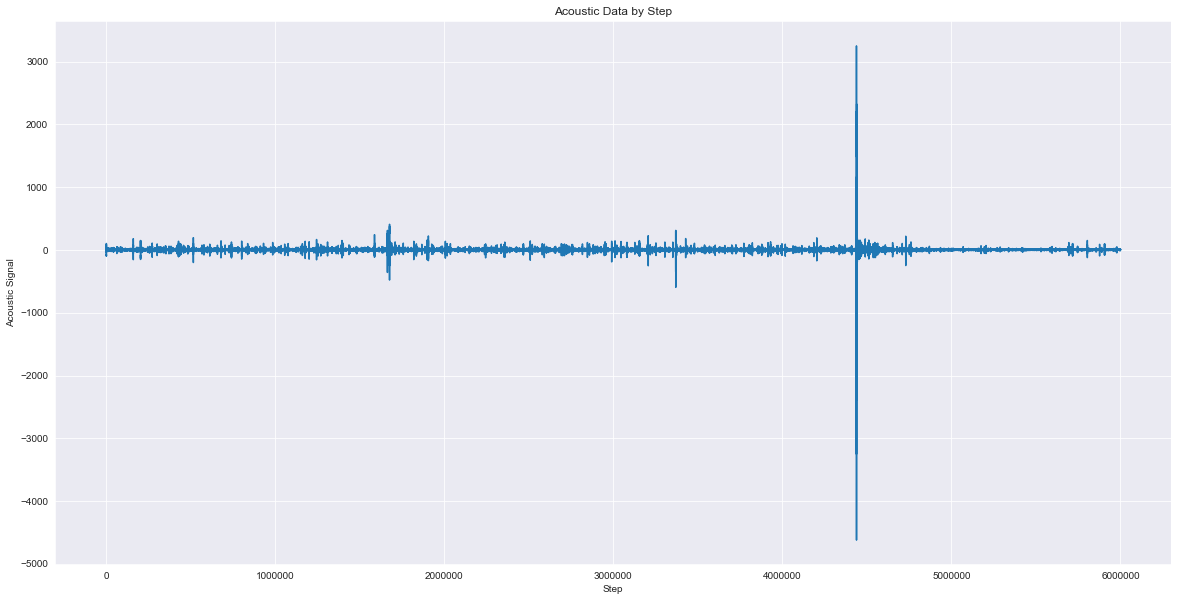

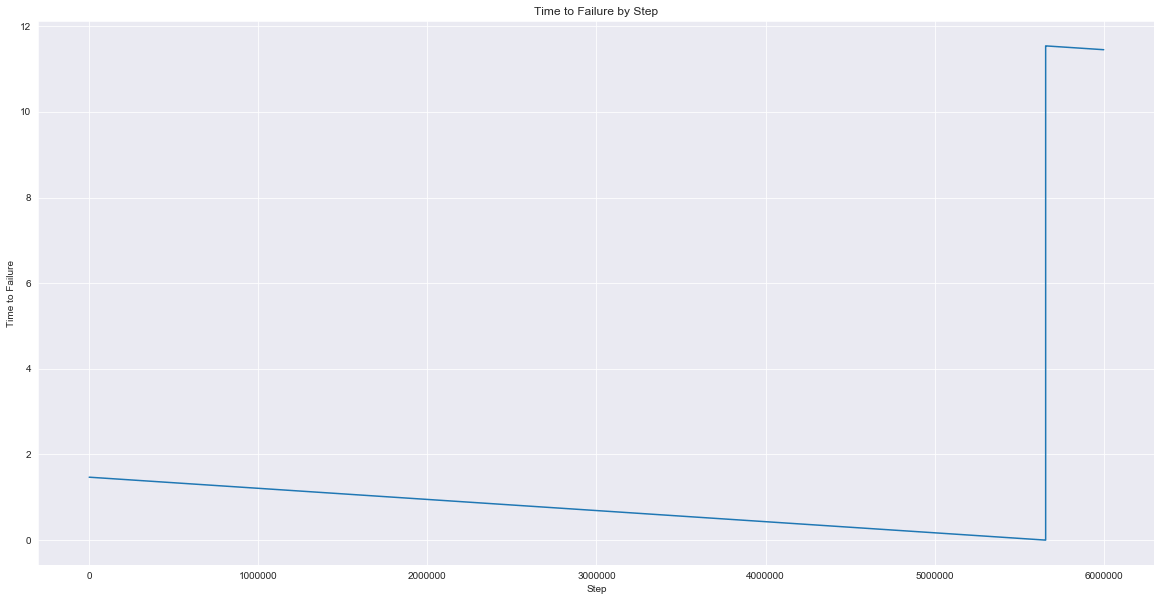

In [3]:
acoustic_data_sample = df.acoustic_data.values[:6000000]
time_to_failure = df.time_to_failure.values[:6000000]

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(time_to_failure)), acoustic_data_sample)
plt.title('Acoustic Data by Step')
plt.xlabel('Step')
plt.ylabel('Acoustic Signal')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(time_to_failure)), time_to_failure)
plt.title('Time to Failure by Step')
plt.xlabel('Step')
plt.ylabel('Time to Failure')
plt.show()

# Basic Analysis

In [4]:
# Label each data segment based on when time_to_failure starts and ends.
dask_df['time_to_failure_rounded'] = dask_df['time_to_failure'].round(2)
aggs = dask_df.groupby('time_to_failure_rounded')['acoustic_data'].agg([np.mean, np.std, np.size, np.min, np.max]).compute()
aggs.head()

,mean,std,size,amin,amax
time_to_failure_rounded,,,,,
0.00,4.595686,3.918224,311295,-71,77
0.01,4.574912,3.756051,614383,-112,129
0.02,4.520883,3.608256,606222,-89,83
0.03,4.552064,3.921865,622596,-99,110
0.04,4.558387,3.933506,614400,-182,180


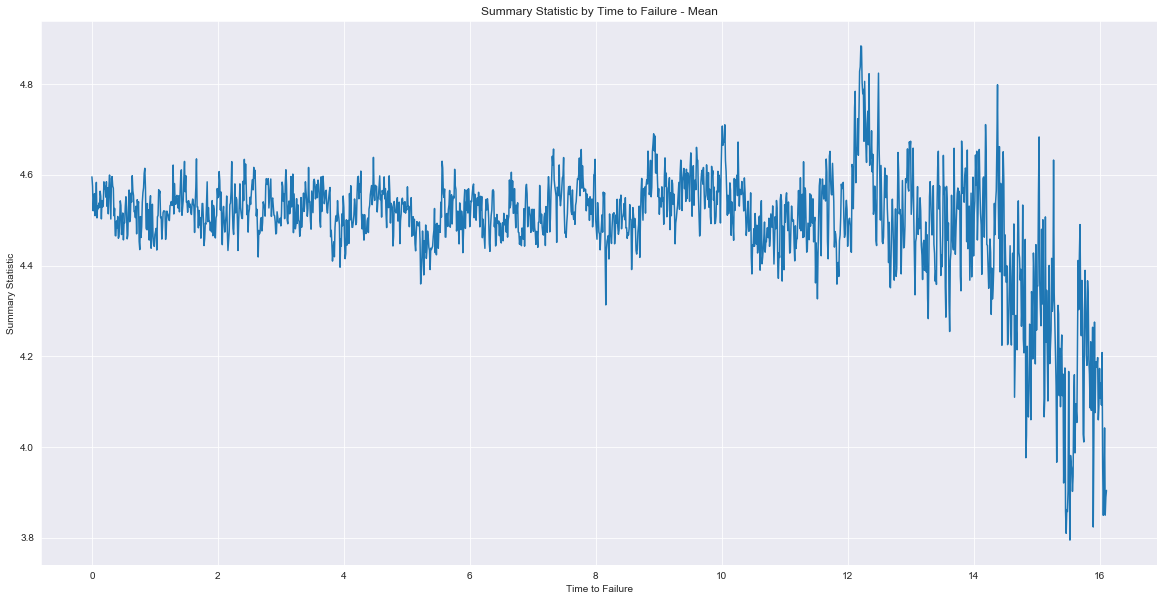

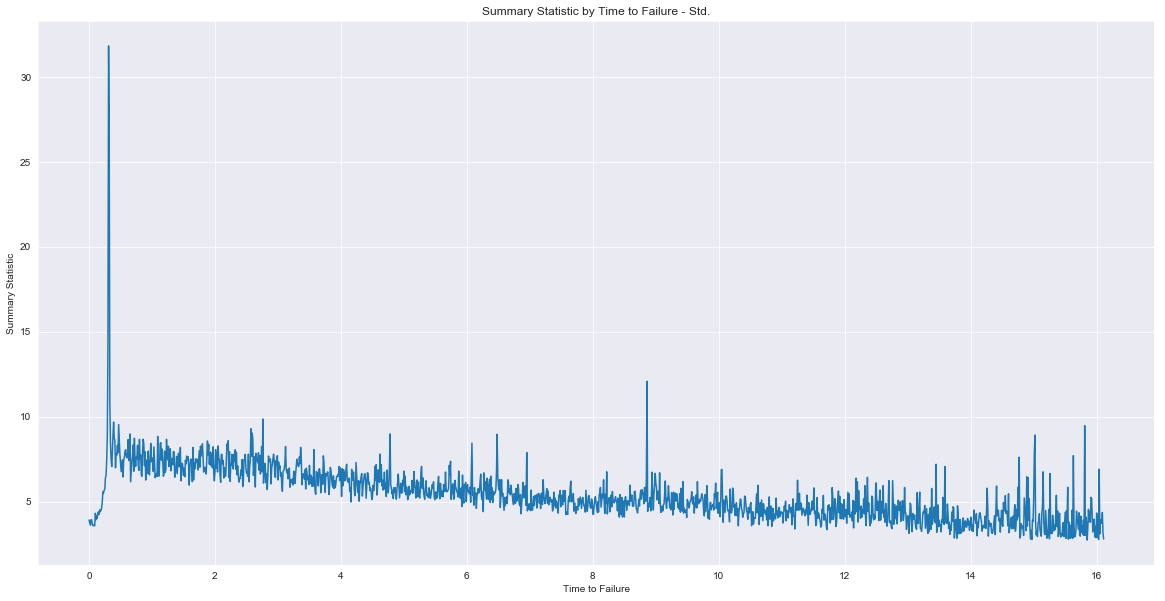

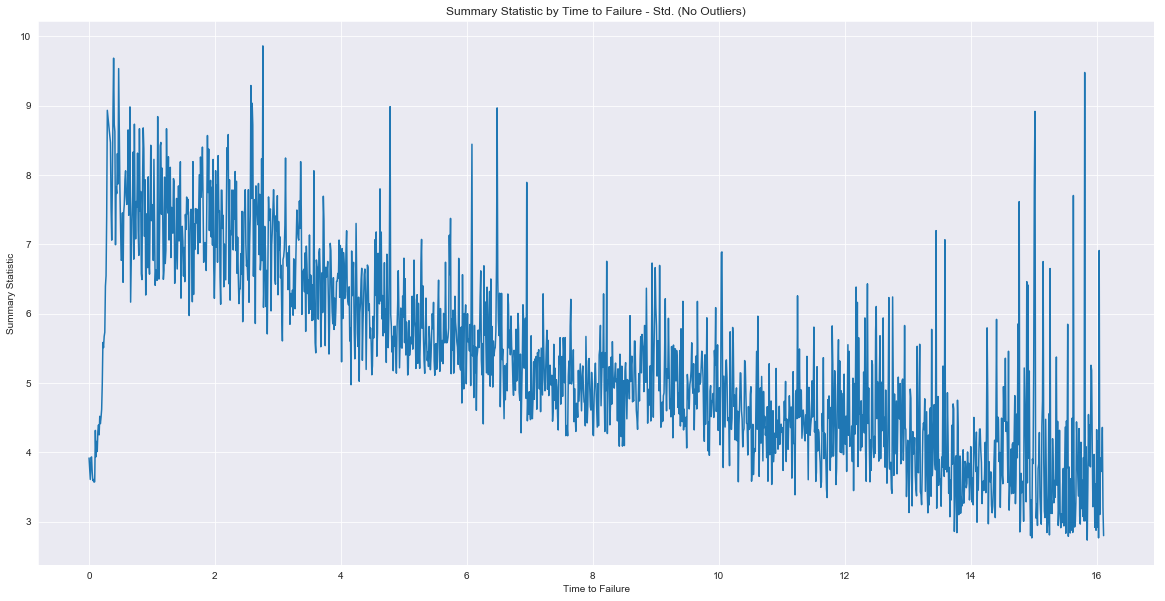

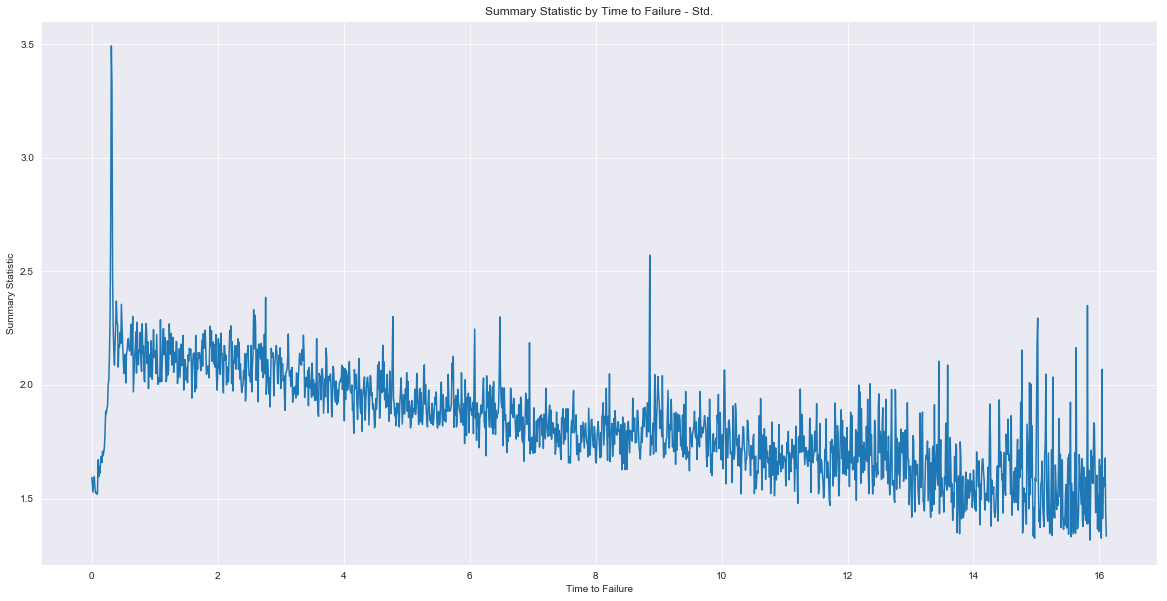

In [5]:
plt.figure(figsize=(20, 10))
plt.plot(aggs.index.values, aggs['mean'])
plt.title('Summary Statistic by Time to Failure - Mean')
plt.xlabel('Time to Failure')
plt.ylabel('Summary Statistic')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(aggs.index.values, aggs['std'])
plt.title('Summary Statistic by Time to Failure - Std.')
plt.xlabel('Time to Failure')
plt.ylabel('Summary Statistic')
plt.show()

stds = aggs['std'].values
plt.figure(figsize=(20, 10))
plt.plot(aggs.index.values[stds < 10], stds[stds < 10])
plt.title('Summary Statistic by Time to Failure - Std. (No Outliers)')
plt.xlabel('Time to Failure')
plt.ylabel('Summary Statistic')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(aggs.index.values, np.log(aggs['std'] + 1))
plt.title('Summary Statistic by Time to Failure - Std.')
plt.xlabel('Time to Failure')
plt.ylabel('Summary Statistic')
plt.show()

The mean seems to deteorite logarithmically, and could potentially be very useful as a "seed" for another estimator. 

The standard deviation displays some interesting properties. There is a huge outlier near zero that skews the entire plot, and there seem to be more outliers as we approach zero. However, if we do some very basic outlier trimming we see the variance increases as a function of the `time_to_failure` before dropping off near zero.

Combining these two terms, and perhaps other time series features, could be very useful in provide a more powerful model a good initial guess at `time_to_failure`.

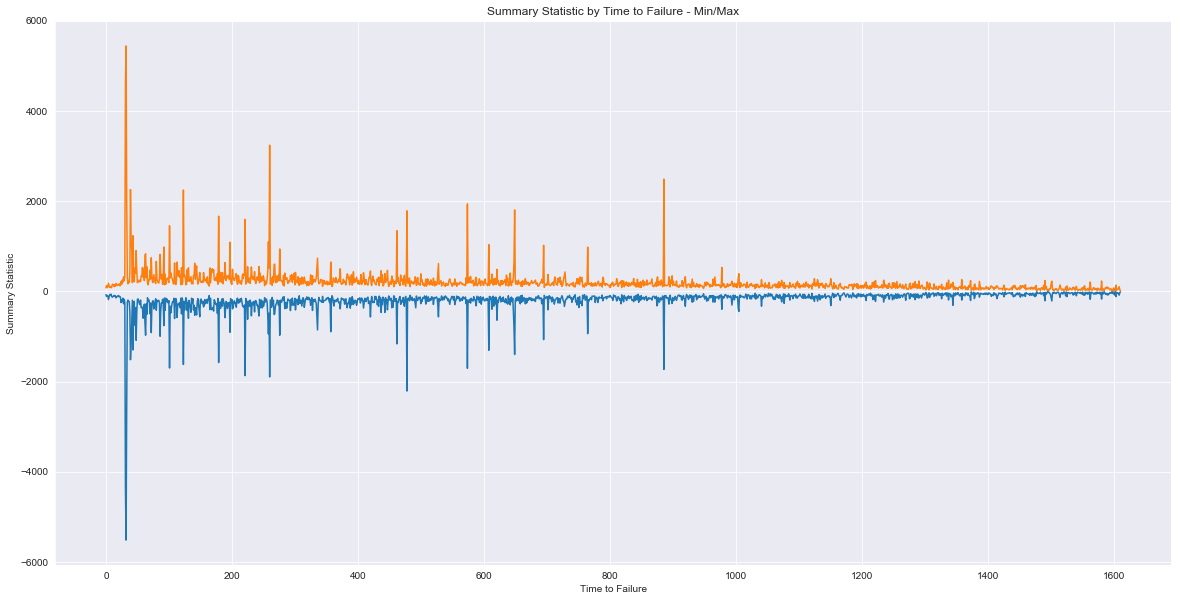

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(aggs)), aggs['amin'], label='Min')
plt.plot(np.arange(len(aggs)), aggs['amax'], label='Max')
plt.title('Summary Statistic by Time to Failure - Min/Max')
plt.xlabel('Time to Failure')
plt.ylabel('Summary Statistic')
plt.show()

It's tough to say whether this gives us any additional information that `std` doesn't already provide. We note that both max and min seem to increase as we approach zero, so the variance occurs on both sides of the x-axis.

In [7]:
# Label each data segment based on when time_to_failure starts and ends.
aggs = dask_df.groupby('acoustic_data')['time_to_failure'].agg([np.mean, np.std, np.size, np.min, np.max]).compute()
aggs.head()

,mean,std,size,amin,amax
acoustic_data,,,,,
-5515,0.316897,NaN,1,0.316897,0.316897
-5474,0.316897,NaN,1,0.316897,0.316897
-5251,0.316897,NaN,1,0.316897,0.316897
-5135,0.316897,NaN,1,0.316897,0.316897
-5008,0.318796,NaN,1,0.318796,0.318796


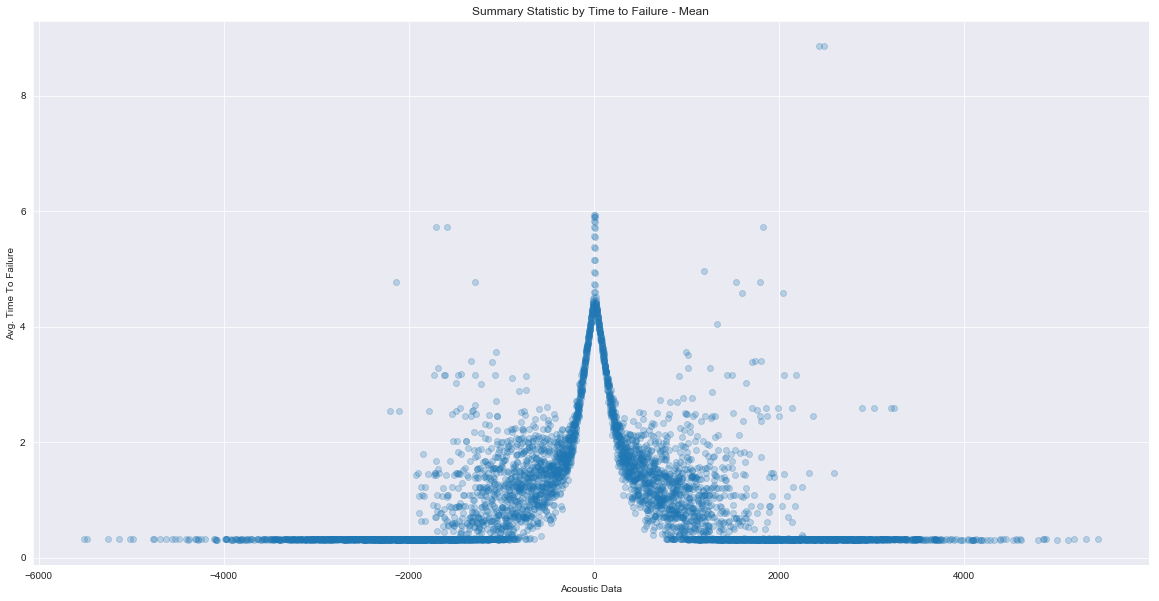

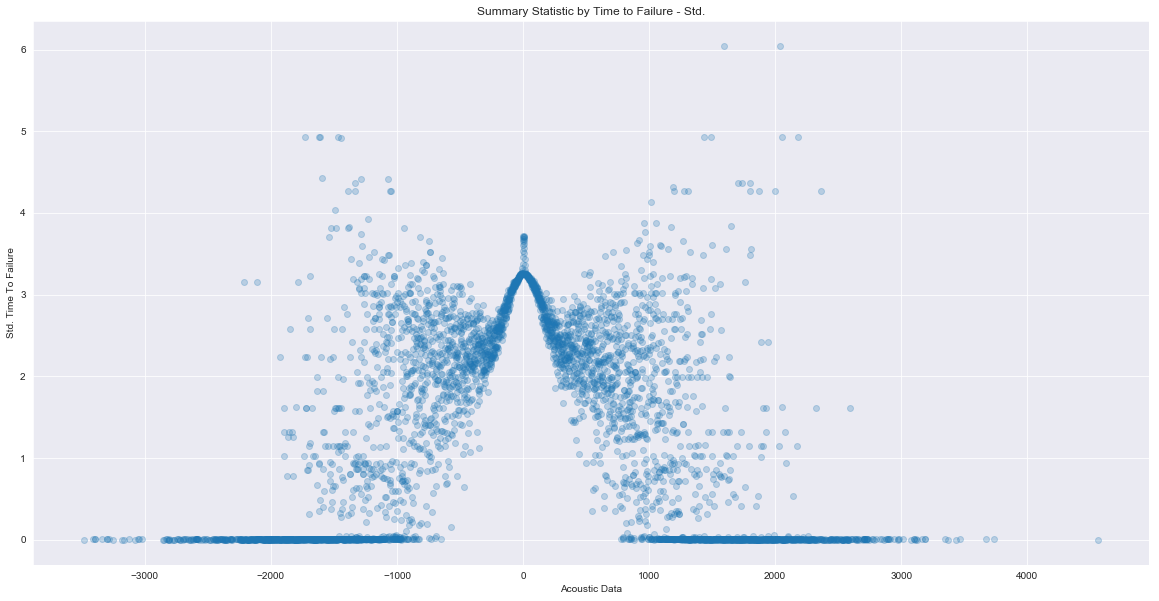

In [8]:
plt.figure(figsize=(20, 10))
plt.scatter(aggs.index.values, aggs['mean'], alpha=.25)
plt.title('Summary Statistic by Time to Failure - Mean')
plt.xlabel('Acoustic Data')
plt.ylabel('Avg. Time To Failure')
plt.show()

plt.figure(figsize=(20, 10))
plt.scatter(aggs.index.values, aggs['std'], alpha=.25)
plt.title('Summary Statistic by Time to Failure - Std.')
plt.xlabel('Acoustic Data')
plt.ylabel('Std. Time To Failure')
plt.show()

The plot is roughly symmetric, and displays a much tighter range about the zero point. It looks like it may be informative to check the diffs on this distribution.

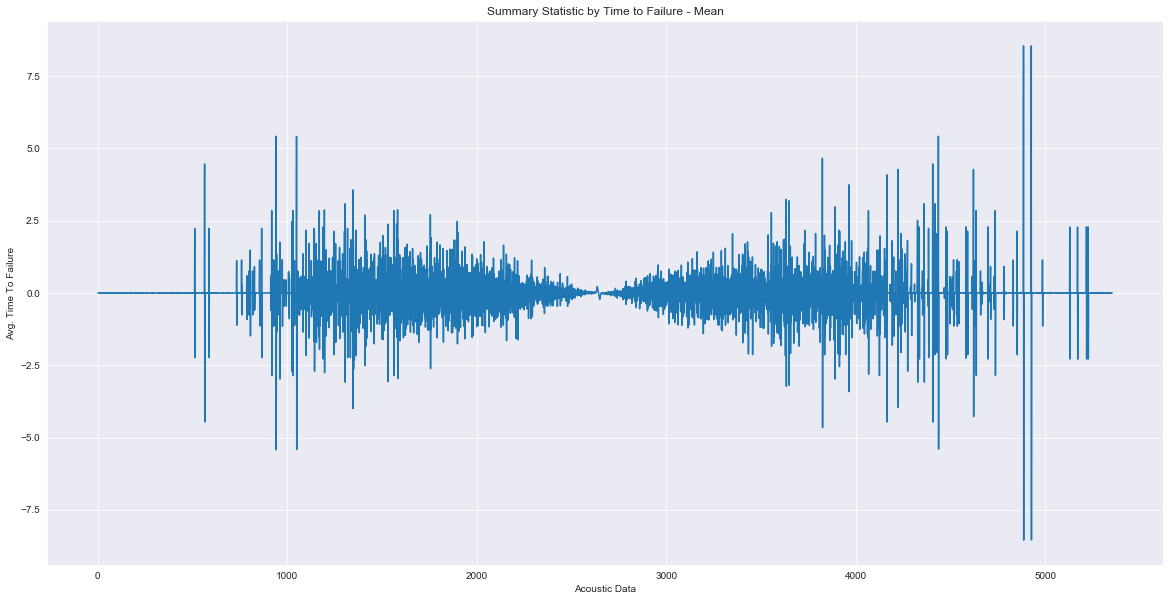

In [9]:
diffs = np.diff(aggs['mean'])

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(diffs)), diffs)
plt.title('Summary Statistic by Time to Failure - Mean')
plt.xlabel('Acoustic Data')
plt.ylabel('Avg. Time To Failure')
plt.show()

# Segment Windows

In order to provide a train set that is much more similar to the test set, we'll attempt to segment windows in such a way that we have all of the data preceding each "zero".

In [10]:
window_idx = [0] + sorted(df[df.time_to_failure.diff() > .1].index.tolist())
all_windows = [df.iloc[v1:v2] for v1, v2 in zip(window_idx[:-1], window_idx[1:])]

Each "window" is formed when there is a jump in timestamp diffs. Since the data is sampled 3-4MHz (up to the limitations of the device, anyway) then we can conclude that each window is formed when we see a discontinuity.

This is helpful to try to emulate something similar to the testing data. Now we can take a glance at certain window level characteristics.

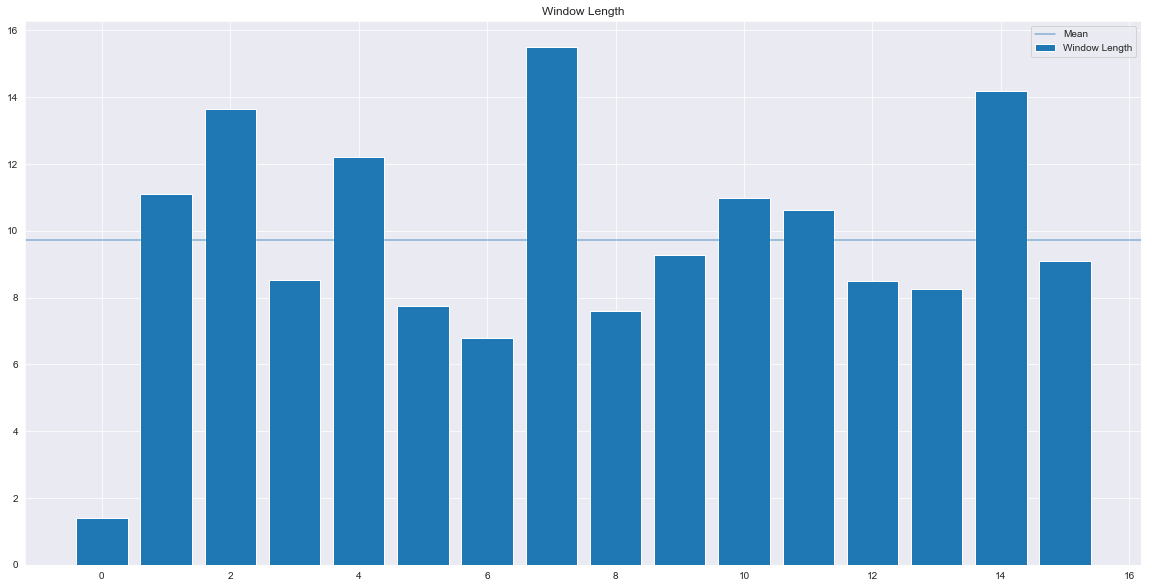

In [11]:
# Compute the length of each window.
wlens = [len(sample) * (1 / 4e6) for sample in all_windows]

plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(wlens)), wlens, label='Window Length')
plt.axhline(np.mean(wlens), alpha=.5, label='Mean')
plt.legend()
plt.title('Window Length')
plt.show()

# Filter Analysis

This data is incredibly noisey! Let's try and apply some filters to get a cleaner dataset.

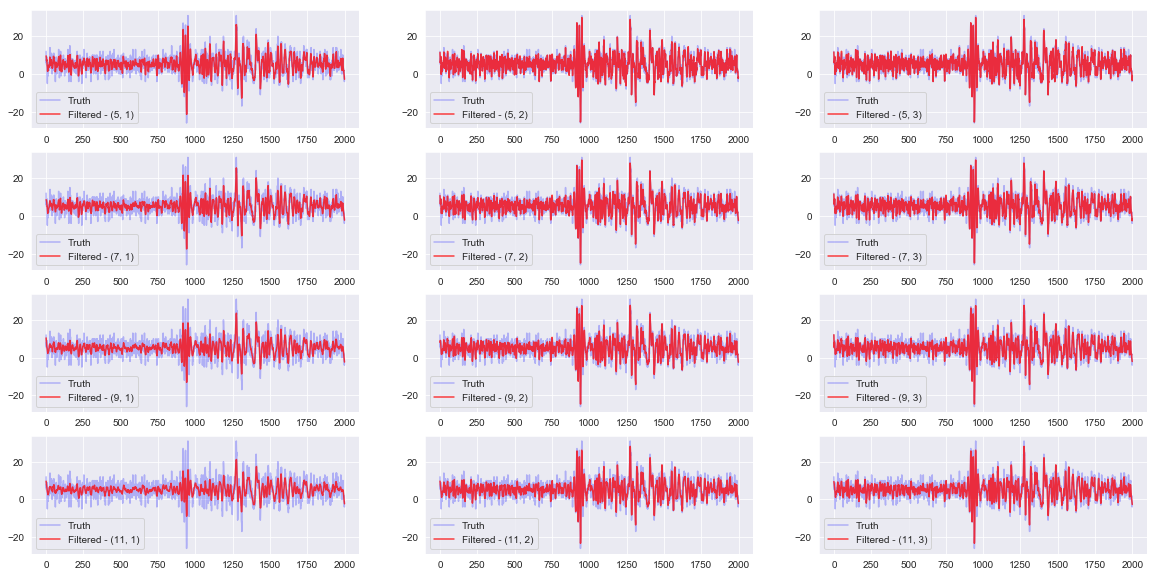

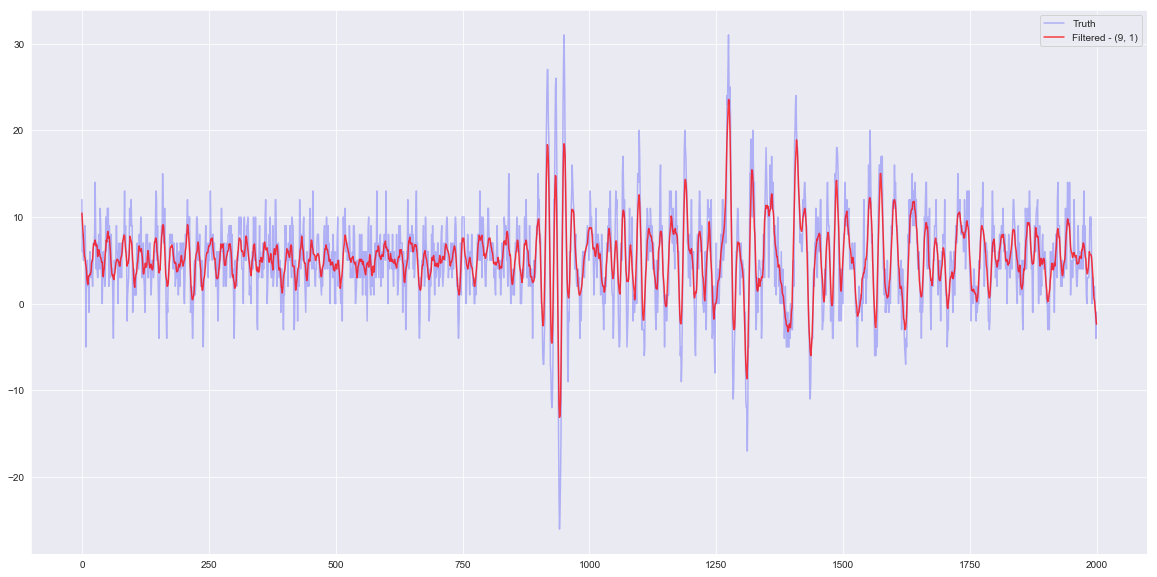

In [25]:
from scipy.signal import butter, filtfilt, savgol_filter

sample = df.acoustic_data.values[:2000]

counter = 1
plt.figure(figsize=(20, 10))
for length in [5, 7, 9, 11]:
    for order in [1, 2, 3]:
        filtered = savgol_filter(sample, length, order)
        plt.subplot(4, 3, counter)
        plt.plot(sample, alpha=.25, color='Blue', label='Truth')
        plt.plot(filtered, alpha=.75, color='Red', label=f'Filtered - {length, order}')
        plt.legend()
        
        counter += 1
        
plt.show()

filtered = savgol_filter(sample, 9, 1)
plt.figure(figsize=(20, 10))
plt.plot(sample, alpha=.25, color='Blue', label='Truth')
plt.plot(filtered, alpha=.75, color='Red', label=f'Filtered - {9, 1}')
plt.legend()
plt.show()

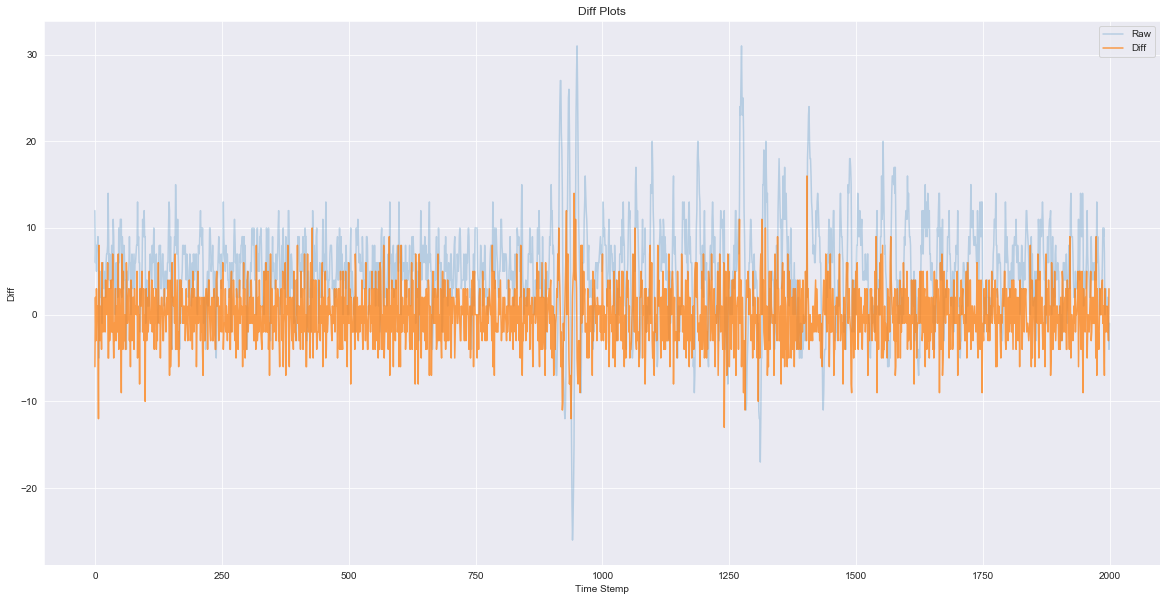

In [13]:
# Do the diffs of our samples tell us anything?
sample = df.acoustic_data.values[:2000]

plt.figure(figsize=(20, 10))
plt.title('Diff Plots')
plt.xlabel('Time Stemp')
plt.ylabel('Diff')
plt.plot(sample, alpha=.25, label='Raw')
plt.plot(np.diff(sample), alpha=.75, label='Diff')
plt.legend()
plt.show()

That certainly produces an interesting series! It appears to be more closely centered around zero, and might be a little less noisey and extreme. However, some smaller bumps seem to get passed over.

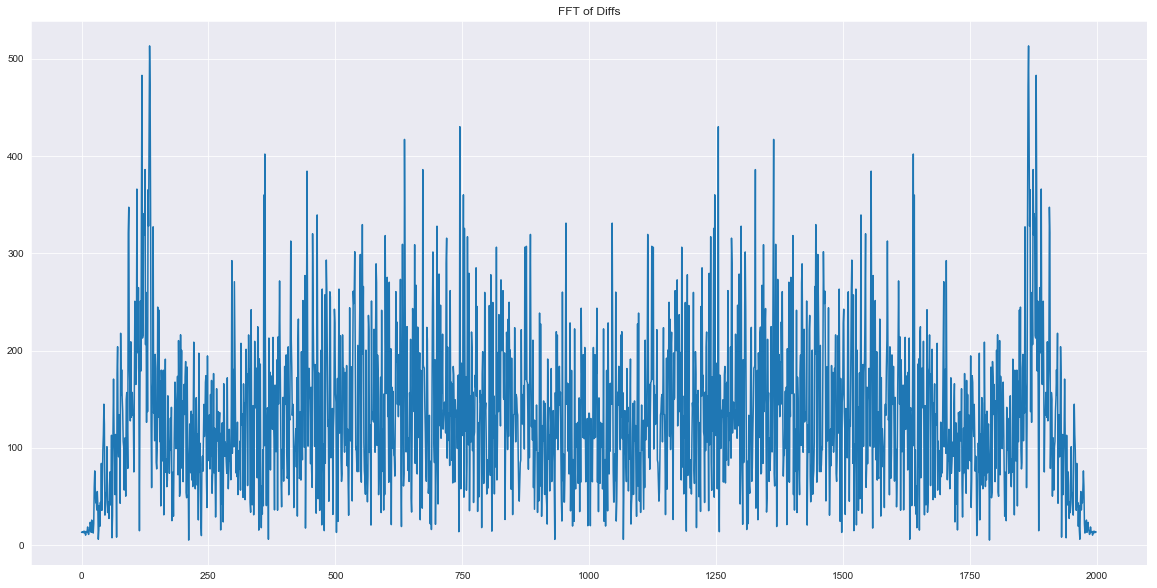

In [16]:
# Do the diffs of our samples tell us anything?
sample = abs(fft(np.diff(df.acoustic_data.values[:2000])))

plt.figure(figsize=(20, 10))
plt.title('FFT of Diffs')
plt.plot(sample)
plt.show()